# 章节介绍
从本章开始正式接触深度神经网络，一个最简单的神经网络就是多层感知机。它是由多个层组成的，每层接着下一层。层与层之间的连接就涉及激活函数的问题，避免模型失效；深度网络层增加就要讨论过拟合和欠拟合的问题，这里涉及到权重衰减和暂退法等正则化技术。另外，模型的初始化，也具有重要的作用。


# 4.1 多层感知器
上一章提到的线性模型，是带有偏置项的仿射变换，输出是和输出具有线性的假设，但是在一些情况会导致失效。注意一点，线性模型是线性模型，多层感知机是多层感知机

## 4.1.1 隐藏层

### 4.1.1.1 线性模型的局限性
线性模型意味着：特征变大，输出也按比例变大或变小；各个输出特征之间互不联系，独立影响输出。

这在一些情况是合理的，如书中举的两个例子：
1. 收入和还款问题
- 收入增加和还款概率增加，是单调的，但这不是线性的，因为收入从0到5万比从100万到105万还款的概率更高。我们可以通过对收入取log来降级量级的影响，使其更加具有线性增加模型表现
2. 体温和死亡率
- 大于37度时候，温度越高，死亡率越大；小于37度时候，温度越低，死亡率越大。这虽然不是线性，但是我们可以通过|体温-37|**数据预处理**让其和死亡率呈线性

但是在一些情况是不合理的，如果你要分辨猫和狗的照片，你能靠"某个单独像素的亮度"判断吗？

- 当然不能了，因为单个像素的亮度不能代表什么，需要融合像素周边上下文的特征才能更好的判断，如狗鼻子周围像素组合出来的模式更能区分狗的特征。在图片分类中像素与像素之间的组合特征再试更加重要的，依靠单个像素很难的！ 

你可能会问？上一章中，fashion——mnist图片数据集为什么可以？这是因为背景是干干净净的，不同衣服形状不一样，表现的像素集中位置不一样，所以能够捕捉一定的模型。

综上，能够体现多层感知器的必要性了，**能够基于多个层去自主的选择和组合特征**


### 4.1.2 在网络中加入隐藏层

线性层组合线性层就是多层感知机了

### 4.1.3 从线性到非线性 & 通用近似定理
单纯的线性层组合线性层，其实就是相当于一个线性层，在不同层之间需要增加激活函数的，让线性变得非线性。

多层感知器可以通过隐藏层的神经元，捕捉输入数据的复杂关系，它就是一个通用的近似器，能够拟合任意函数。理论上单隐含层的多层感知器就能拟合任意函数，但是通常我们会通过更深而窄的多层感知机来进行拟合。



## 4.1.2 激活函数
激活函数根据上一层输入神经元的值来决定是否需要被激活，是非线性的，下面看下常见的损失函数，了解原理和性质见[哔哩哔哩-激活函数](https://www.bilibili.com/video/BV1qB4y1e7GJ/?share_source=copy_web&vd_source=68b6db5fa01ed9ec60298a450c45bc63)

最受欢迎的激活函数是修正线性单元（Rectified linear unit，ReLU）， 因为它实现简单，同时在各种预测任务中表现良好。

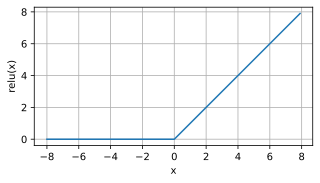

In [3]:
import torch
from d2l import torch as d2l

x = torch.arange(-8, 8, 0.1, requires_grad=True)
y = torch.relu(x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

使用relu激活函数的原因是，它求导表现好：让么让梯度消失，要么不变，控制神经元是否激活。它解决了神经网络梯度消失的问题。

对于relu激活函数还有leaky-relu、p-relu等变体。

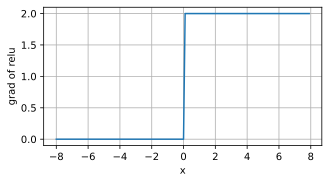

In [13]:
# 求导
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

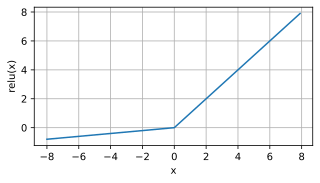

In [4]:
# prelu
alpha = torch.nn.Parameter(torch.tensor(0.1))
y = torch.prelu(x, alpha)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

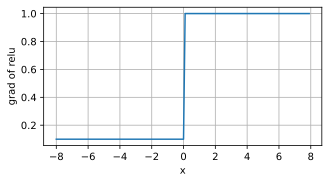

In [5]:
# 求导
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

sigmoid激活函数

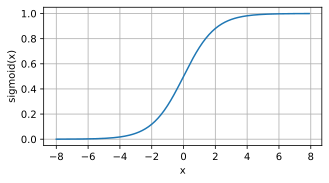

In [14]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

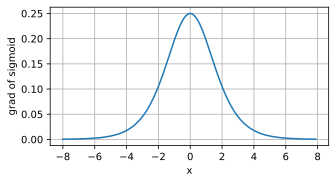

In [15]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

tanh(双曲正切)函数也能将其输入压缩转换到区间(-1, 1)上，当输入在0附近时，tanh函数接近线性变换。 函数的形状类似于sigmoid函数， 不同的是tanh函数关于坐标系原点中心对称。

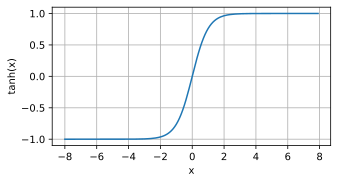

In [16]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

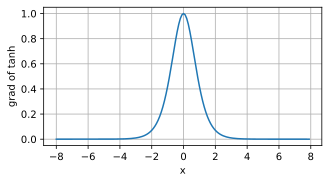

In [17]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 4.2 从零开始实现多层感知机

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

# 依旧使用fashion_mnist数据集

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

定义参数和激活函数和模型

In [17]:
num_inputs, num_outputs, num_hiddien = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddien, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddien, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddien, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

def net(x):
    h = relu(torch.matmul(x.reshape(-1, 784), W1) + b1)
    o = torch.matmul(h, W2) + b2 
    return o

x = torch.randn(10, 28, 28) * 0.01
x = net(x)
x.shape

torch.Size([10, 10])

定义loss和优化器

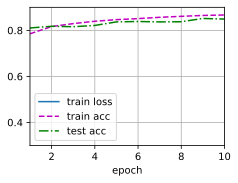

In [19]:
loss = nn.CrossEntropyLoss(reduce='None')

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

### 练习
如果想要构建多个超参数的搜索方法，请想出一个聪明的策略？
使用 Optuna 搭配你的 PyTorch 训练进行调参  

# 4.3 简洁实现多层感知机

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.Sigmoid(),
                    nn.Linear(256, 10))

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

AssertionError: 0.5002324857076009

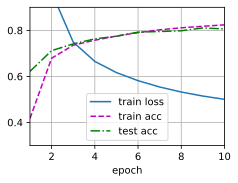

In [5]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

尝试不同的方案来初始化权重，什么方法效果最好？

| 初始化方法                | 适用层类型              | 特点和效果                       |
| -------------------- | ------------------ | --------------------------- |
| **Xavier (Glorot)**  | `Linear`, `Conv` 等 | 适用于 sigmoid / tanh，保持激活方差稳定 |
| **Kaiming (He)**     | `ReLU` 系激活的网络      | 保持正向传播和反向梯度的方差一致            |
| **Orthogonal**       | `Linear` 层         | 保留向量独立性，适合 RNN 等序列模型        |
| **Uniform / Normal** | 任何层（不推荐默认用）        | 无特殊优化，可能导致梯度消失或爆炸           |
| **Pretrained 初始化**   | NLP、CV 等           | 利用大模型的参数，几乎总是最优起点           |

没有一种初始化方法在所有情况下都是最好的，但经验上：

使用 ReLU：推荐 Kaiming 初始化，训练更稳定

使用 Sigmoid / Tanh：推荐 Xavier 初始化

RNN / LSTM / Transformer 等结构：常配合 Orthogonal 或自定义方案

深层 CNN / ResNet 等结构：Kaiming 是默认选项（也是 PyTorch 默认）

NLP 中 Transformer：通常使用 特定的初始化规则（比如 BERT 的正态分布）

# 4.4 模型选择、欠拟合和过拟合

作为机器学习科学家，我们的目标是发现模式（pattern）。 确定模型是真正发现了一种泛化的模式， 而不是简单地记住了数据.

模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合（overfitting）， 用于对抗过拟合的技术称为正则化（regularization）

## 4.4.1. 训练误差和泛化误差
1. 训练练误差（training error）是指， 模型在训练数据集上计算得到的误差。 泛化误差（generalization error）是指， 模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

2. 目前已探讨、并将在之后继续探讨的监督学习情景中， 我们假设训练数据和测试数据都是从相同的分布中独立提取的。 这通常被称为独立同分布假设（i.i.d. assumption）， 这意味着对数据进行采样的过程没有进行“记忆”。

3. 即使轻微违背独立同分布假设，模型仍将继续运行得非常好。

4. 模型复杂性由什么构成是一个复杂的问题。 一个模型是否能很好地泛化取决于很多因素：
    - 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。
    - 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
    - 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 4.4.2. 模型如何选择？

1. 将我们的数据分成三份， 除了训练和测试数据集之外，还增加一个验证数据集（validation dataset）。实际上测试集和训练集边界很难界定，一般大家默认就训练集和测试集，或者说训练集和验证集。

2. K折交叉验证：原始训练数据被分成K个不重叠的子集。 然后执行K次模型训练和验证，每次在K-1个子集上进行训练， 并在剩余的一个子集上进行验证。


## 4.4.3. 欠拟合还是过拟合？

1. 训练误差和验证误差都很严重， 但它们之间仅有一点差距。 如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足）， 无法捕获试图学习的模式。这种现象被称为欠拟合（underfitting）

2. 当我们的训练误差明显低于验证误差时要小心， 这表明严重的过拟合（overfitting）

## 4.4.4. 多项式回归
通过多项式回归来探索上述的概念

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

生成数据集

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.9015],
         [1.7778]]),
 tensor([[1.0000e+00, 9.0152e-01, 4.0637e-01, 1.2212e-01, 2.7523e-02, 4.9624e-03,
          7.4562e-04, 9.6028e-05, 1.0821e-05, 1.0840e-06, 9.7721e-08, 8.0089e-09,
          6.0168e-10, 4.1725e-11, 2.6869e-12, 1.6148e-13, 9.0988e-15, 4.8252e-16,
          2.4166e-17, 1.1467e-18],
         [1.0000e+00, 1.7778e+00, 1.5803e+00, 9.3645e-01, 4.1620e-01, 1.4798e-01,
          4.3847e-02, 1.1136e-02, 2.4746e-03, 4.8882e-04, 8.6902e-05, 1.4045e-05,
          2.0807e-06, 2.8454e-07, 3.6133e-08, 4.2824e-09, 4.7582e-10, 4.9760e-11,
          4.9145e-12, 4.5984e-13]]),
 tensor([5.3740, 6.9726]))

对模型进行训练和测试

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.9942355  1.2573986 -3.412222   5.492894 ]]


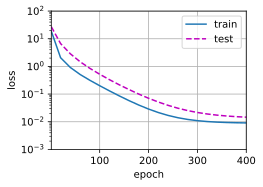

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.6677446 2.5872066]]


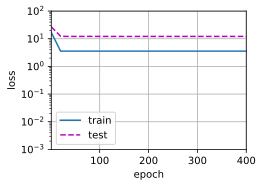

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.96982098e+00  1.29692721e+00 -3.28394508e+00  5.11631155e+00
  -3.62791747e-01  1.45374012e+00 -1.00252934e-01  3.15389305e-01
   8.80059451e-02  1.19037047e-01  1.64379075e-01  1.16645046e-04
   9.05725434e-02 -2.07754537e-01 -2.40244437e-02  1.36785209e-01
   1.56760871e-01 -1.98289007e-02 -1.50988698e-01  1.14703655e-01]]


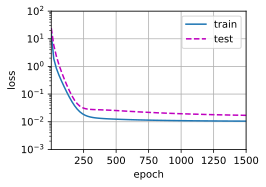

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 4.5. 权重衰减
限制特征的数量是能够缓解过拟合，但是这过于生硬，于是就有了正则化技术。

- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。

- 保持模型简单的一个特别的选择是使用惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。

- 权重衰减功能在深度学习框架的优化器中提供。

- 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

# 4.6 暂退法


In [13]:
import torch
import torch.nn as nn
from d2l import torch as d2l

def dropout_layer(x, dropout):
    assert 0. <= dropout <= 1
    if dropout == 0.:
        return torch.zeros_like(x)
    if dropout == 1.:
        return x
    mask = (torch.rand(x.shape) > dropout).float()

    return mask * x / (1 - dropout)

X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10., 12., 14.],
        [16.,  0., 20.,  0., 24.,  0.,  0., 30.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])


In [14]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

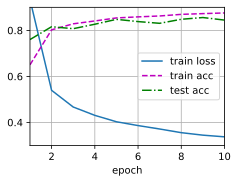

In [15]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

- 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
- 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用的。
- 暂退法将活性值h替换为具有期望值h的随机变量。
- 暂退法仅在训练期间使用。
- 暂退法用在激活函数之后

## 问题
1. 当应用或不应用暂退法时，每个隐藏层中激活值的方差有什么变化？
    - 应用暂退法时，激活值的方差会上升，所以方差 被放大了1/1-p
2. 为什么在测试时通常不使用暂退法？
    - 测试阶段我们希望模型的输出是确定性的，而不是随机的。如果在测试时继续随机丢弃神经元，会导致模型输出波动大，损害性能。
3. 如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？
    - 一个作用于神经元激活，一个作用于权重，通常不会“抵消”，而是可以互补，只是收益边际可能减小。
4. 如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？
    - 应用于权重是可行的，也是一种正则化，但会带来额外复杂性(权重参数数量多)和不稳定性，通常训练更困难  


#  4.7 前向传播、反向传播和计算图

1. 前向传播（forward propagation或forward pass） 指的是：按顺序（从输入层到输出层）计算和存储神经网络中每层的结果
2. 前向传播通过grad_fn记录本层的操作，grad_fn.next_function能够记录参与计算是如何得到的。根据这种关系生成有向无环图的计算图
3. 计算图是动态生成，每次前向传播就会生成，loss.backword()之后就会消失，除非设置retain_graph为true
4. with torch no_grad表示不生成计算图，detach()表示从计算图中分离
5. 反向传播（backward propagation或backpropagation）指的是计算神经网络参数梯度的方法。

# 4.8 数值稳定性和模型初始化

模型参数初始化影响参数训练的问题性，会导致梯度消失或爆炸以及参数对称性的话则模型学不到东西。
1. 梯度消失和梯度爆炸，由于梯度计算是根据链式法则，当这个链路过长，中间梯度都很小那么就会梯度消失，都很大就会梯度爆炸。
2. 参数化具有对称性，也不行，如全是一样的数，这样会导致每层输出的激活值一样，进而下一层输出也一样，梯度计算出来都一样，那么模型参数相当于不会变化
3. 参数初始化办法：默认参数初始化、Xavier、kaiming初始化、正交初始化

### 4.8.1 小结
- 梯度消失和梯度爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
- ReLU激活函数缓解了梯度消失问题，这样可以加速收敛
- 随机初始化是保证在进行优化前打破对称性的关键。
- Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。

# 4.9. 环境和分布偏移

## 4.9.1. 分布偏移的类型
1. 协变量偏移:虽然输入的分布可能随时间而改变， 但标签函数（即条件分布）没有改变，也就是训练和测试数据分布不一致
2. 标签偏移：描述了与协变量偏移相反的问题，训练数据的标签对应不上
3. 概念偏移：当标签的定义发生变化时，就会出现这种问题